### Informacion del Datasets

El conjunto de datos contiene transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos.
Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284,807 transacciones. El conjunto de datos está muy desequilibrado: la clase positiva (fraudes) representa el 0,172% de todas las transacciones.

Contiene sólo variables de entrada numéricas que son el resultado de una transformación PCA. Lamentablemente, debido a cuestiones de confidencialidad, no podemos proporcionar las características originales ni más información general sobre los datos. Las características V1, V2,… V28 son los componentes principales obtenidos con PCA, las únicas características que no se han transformado con PCA son 'Tiempo' y 'Cantidad'. La característica 'Tiempo' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La característica 'Monto' es el monto de la transacción; esta característica se puede utilizar para el aprendizaje sensible a los costos, por ejemplo. La característica 'Clase' es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

Dada la relación de desequilibrio de clases, recomendamos medir la precisión utilizando el área bajo la curva de recuperación de precisión (AUPRC). La precisión de la matriz de confusión no es significativa para una clasificación desequilibrada.

In [45]:
# Importamos librerias para manipulacion, proceso, y calclos de datos 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import os
import time
from sklearn.model_selection import train_test_split

# Prosesamiento de los datos 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline # Para hacer funiones Propias y agregar multiples funciones
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer

# Prueba t de Student, entre otros 
from scipy.stats import ttest_ind, reciprocal, randint # if p-value<0.05

# Balancear los datos 
from imblearn.over_sampling import SMOTE, RandomOverSampler # Para classes Minoritarias
from imblearn.under_sampling import RandomUnderSampler  # para clases mayoritarias

# Validacion Cruzada 
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score

# ------------------- Modelos sklearn -------------------
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Ajustes de hiperparametros 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# ------------- Red Neuronal -------------------
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

# Ajustes de hiperparametros 
from scikeras.wrappers import KerasClassifier  # forma 1
from keras_tuner import RandomSearch, GridSearch # forma 2, mas optimo

# Metricas del modelo Clasificacion
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix

#Metricas para este problema de estudio 
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, average_precision_score, precision_score, recall_score

from joblib import load, dump

import warnings
warnings.filterwarnings('ignore')

### Leer Y entender el Conjunto de datos 

**Nota: viualizamos y entendemos la problematica de este conjunto de datos**

In [2]:
ruta='../Credit Card Fraud Detection - Classification/creditcard.csv'

def load_dataset(data=ruta):
    path= os.path.join(data)

    return pd.read_csv(path)


In [3]:
df_card= load_dataset()
df_card.head() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [5]:
df_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61087 entries, 0 to 61086
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    61087 non-null  int64  
 1   V1      61087 non-null  float64
 2   V2      61087 non-null  float64
 3   V3      61087 non-null  float64
 4   V4      61087 non-null  float64
 5   V5      61087 non-null  float64
 6   V6      61087 non-null  float64
 7   V7      61087 non-null  float64
 8   V8      61087 non-null  float64
 9   V9      61087 non-null  float64
 10  V10     61087 non-null  float64
 11  V11     61087 non-null  float64
 12  V12     61087 non-null  float64
 13  V13     61086 non-null  float64
 14  V14     61086 non-null  float64
 15  V15     61086 non-null  float64
 16  V16     61086 non-null  float64
 17  V17     61086 non-null  float64
 18  V18     61086 non-null  float64
 19  V19     61086 non-null  float64
 20  V20     61086 non-null  float64
 21  V21     61086 non-null  float64
 22

In [6]:
df_card.shape # (61087, 31)

(61087, 31)

In [7]:
df_card.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,61087.000000,61087.000000,61087.000000,61087.000000,61087.000000,61087.000000,61087.000000,61087.000000,61087.000000,61087.000000,...,61086.000000,61086.000000,61086.000000,61086.000000,61086.000000,61086.000000,61086.000000,61086.000000,61086.000000,61086.000000
mean,32200.002243,-0.237309,-0.009397,0.687714,0.170452,-0.261758,0.102326,-0.114511,0.056258,0.055463,...,-0.028096,-0.107331,-0.040111,0.006063,0.135985,0.020036,0.002559,0.004490,95.466464,0.002668
std,13771.823071,1.859627,1.651911,1.438258,1.382581,1.387176,1.305552,1.246484,1.192884,1.179350,...,0.722748,0.637113,0.589354,0.596566,0.438450,0.498628,0.383059,0.323853,268.948267,0.051588
min,0.000000,-56.407510,-72.715728,-32.965346,-5.172595,-42.147898,-26.160506,-26.548144,-41.484823,-9.283925,...,-20.262054,-10.933144,-26.751119,-2.836627,-7.495741,-2.534330,-8.567638,-9.617915,0.000000,0.000000
25%,26633.500000,-0.994221,-0.582289,0.202581,-0.725451,-0.881091,-0.636578,-0.604529,-0.144360,-0.653601,...,-0.228145,-0.527399,-0.179955,-0.325938,-0.128172,-0.329715,-0.063340,-0.006167,7.680000,0.000000
50%,35976.000000,-0.245059,0.075348,0.778548,0.184631,-0.294729,-0.151280,-0.074053,0.062866,-0.047111,...,-0.063097,-0.082443,-0.052073,0.061227,0.173840,-0.075666,0.009050,0.022641,26.020000,0.000000
75%,42510.000000,1.154780,0.732154,1.411693,1.051733,0.276898,0.492226,0.424943,0.338262,0.722071,...,0.113510,0.308497,0.078637,0.402774,0.422592,0.297798,0.082518,0.076369,87.732500,0.000000
max,49653.000000,1.960497,18.183626,4.101716,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,...,22.614889,5.805795,17.297845,4.014444,5.525093,3.517346,11.135740,33.847808,19656.530000,1.000000


**Nota: Se visualiza que las caracteristicas de v1 hasta v30 estan bien escaladas, no presentas vaores altos, mientras que para las caracteristicas Time, Amount tiene valores muy altos para la mean() y std(), para estas hay que aplicar un tratamiento de escalado, la Variable Objetivo es Class, 1 = Fraude, 0= no fraude (otro)**

### Analisis Exploratorios de los datos (EDA)

- Analsis Estadisticos.
- Variable Importantes.
- Pueva T-student (P_vales).
- Correlaciones.
- Graficar Barras Histrogramas.
- Outliers.
- Data Imbalanceada.
- Esclado de los datos 
- Etc.

In [9]:
# Valores nulos, Faltantes

#df_card.isnull().sum()

df_card[df_card['V21'].isnull()]

# Tenemos 18 valores Faltante o nulos, y estan en la ultima fila 
# puede que se rellen con alguna tecnica, o simplemente se eliminar, ya que no son muchos

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
61086,49653,-0.691979,-0.607178,2.379373,-2.523262,-1.050465,-0.177158,-0.735179,0.295237,-2.391498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Verificamos las clases 

df_card['Class'].value_counts()

Class
0.0    60923
1.0      163
Name: count, dtype: int64

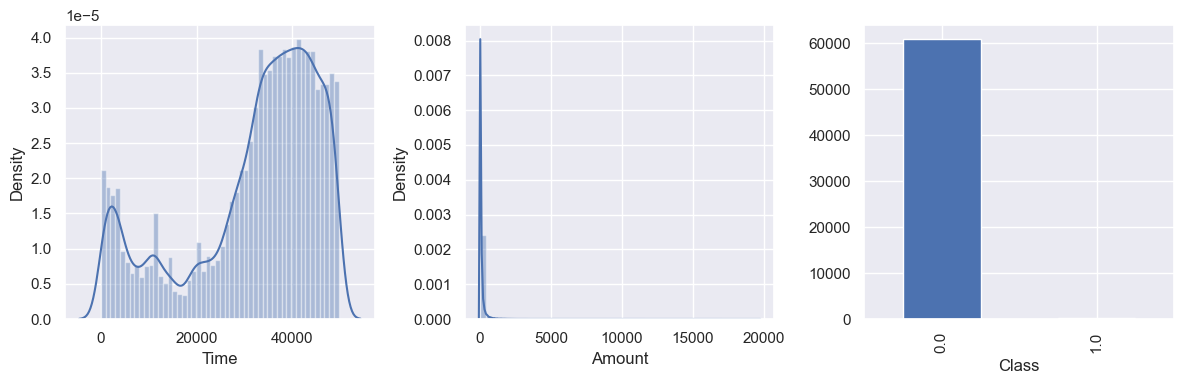

In [45]:
# Graficos de barra, caracteristicas Time, Amount, Class

features = df_card[['Time', 'Amount', 'Class']]

fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
#plt.figure(figsize=(12, 4))
index=0
ax=ax.flatten()

for cat in features.columns:

    if cat in ['Time', 'Amount']:
        sns.distplot(features[cat], kde=True, ax=ax[index]) # histoplot
        index +=1
        
    elif cat in ['Class']:
        df_card[cat].value_counts().plot(kind='bar', ax=ax[index]) # contamos primero y lugo graficamos mas rapido de graficar
        #sns.countplot(name_class)
        index +=1

plt.tight_layout()
plt.show()

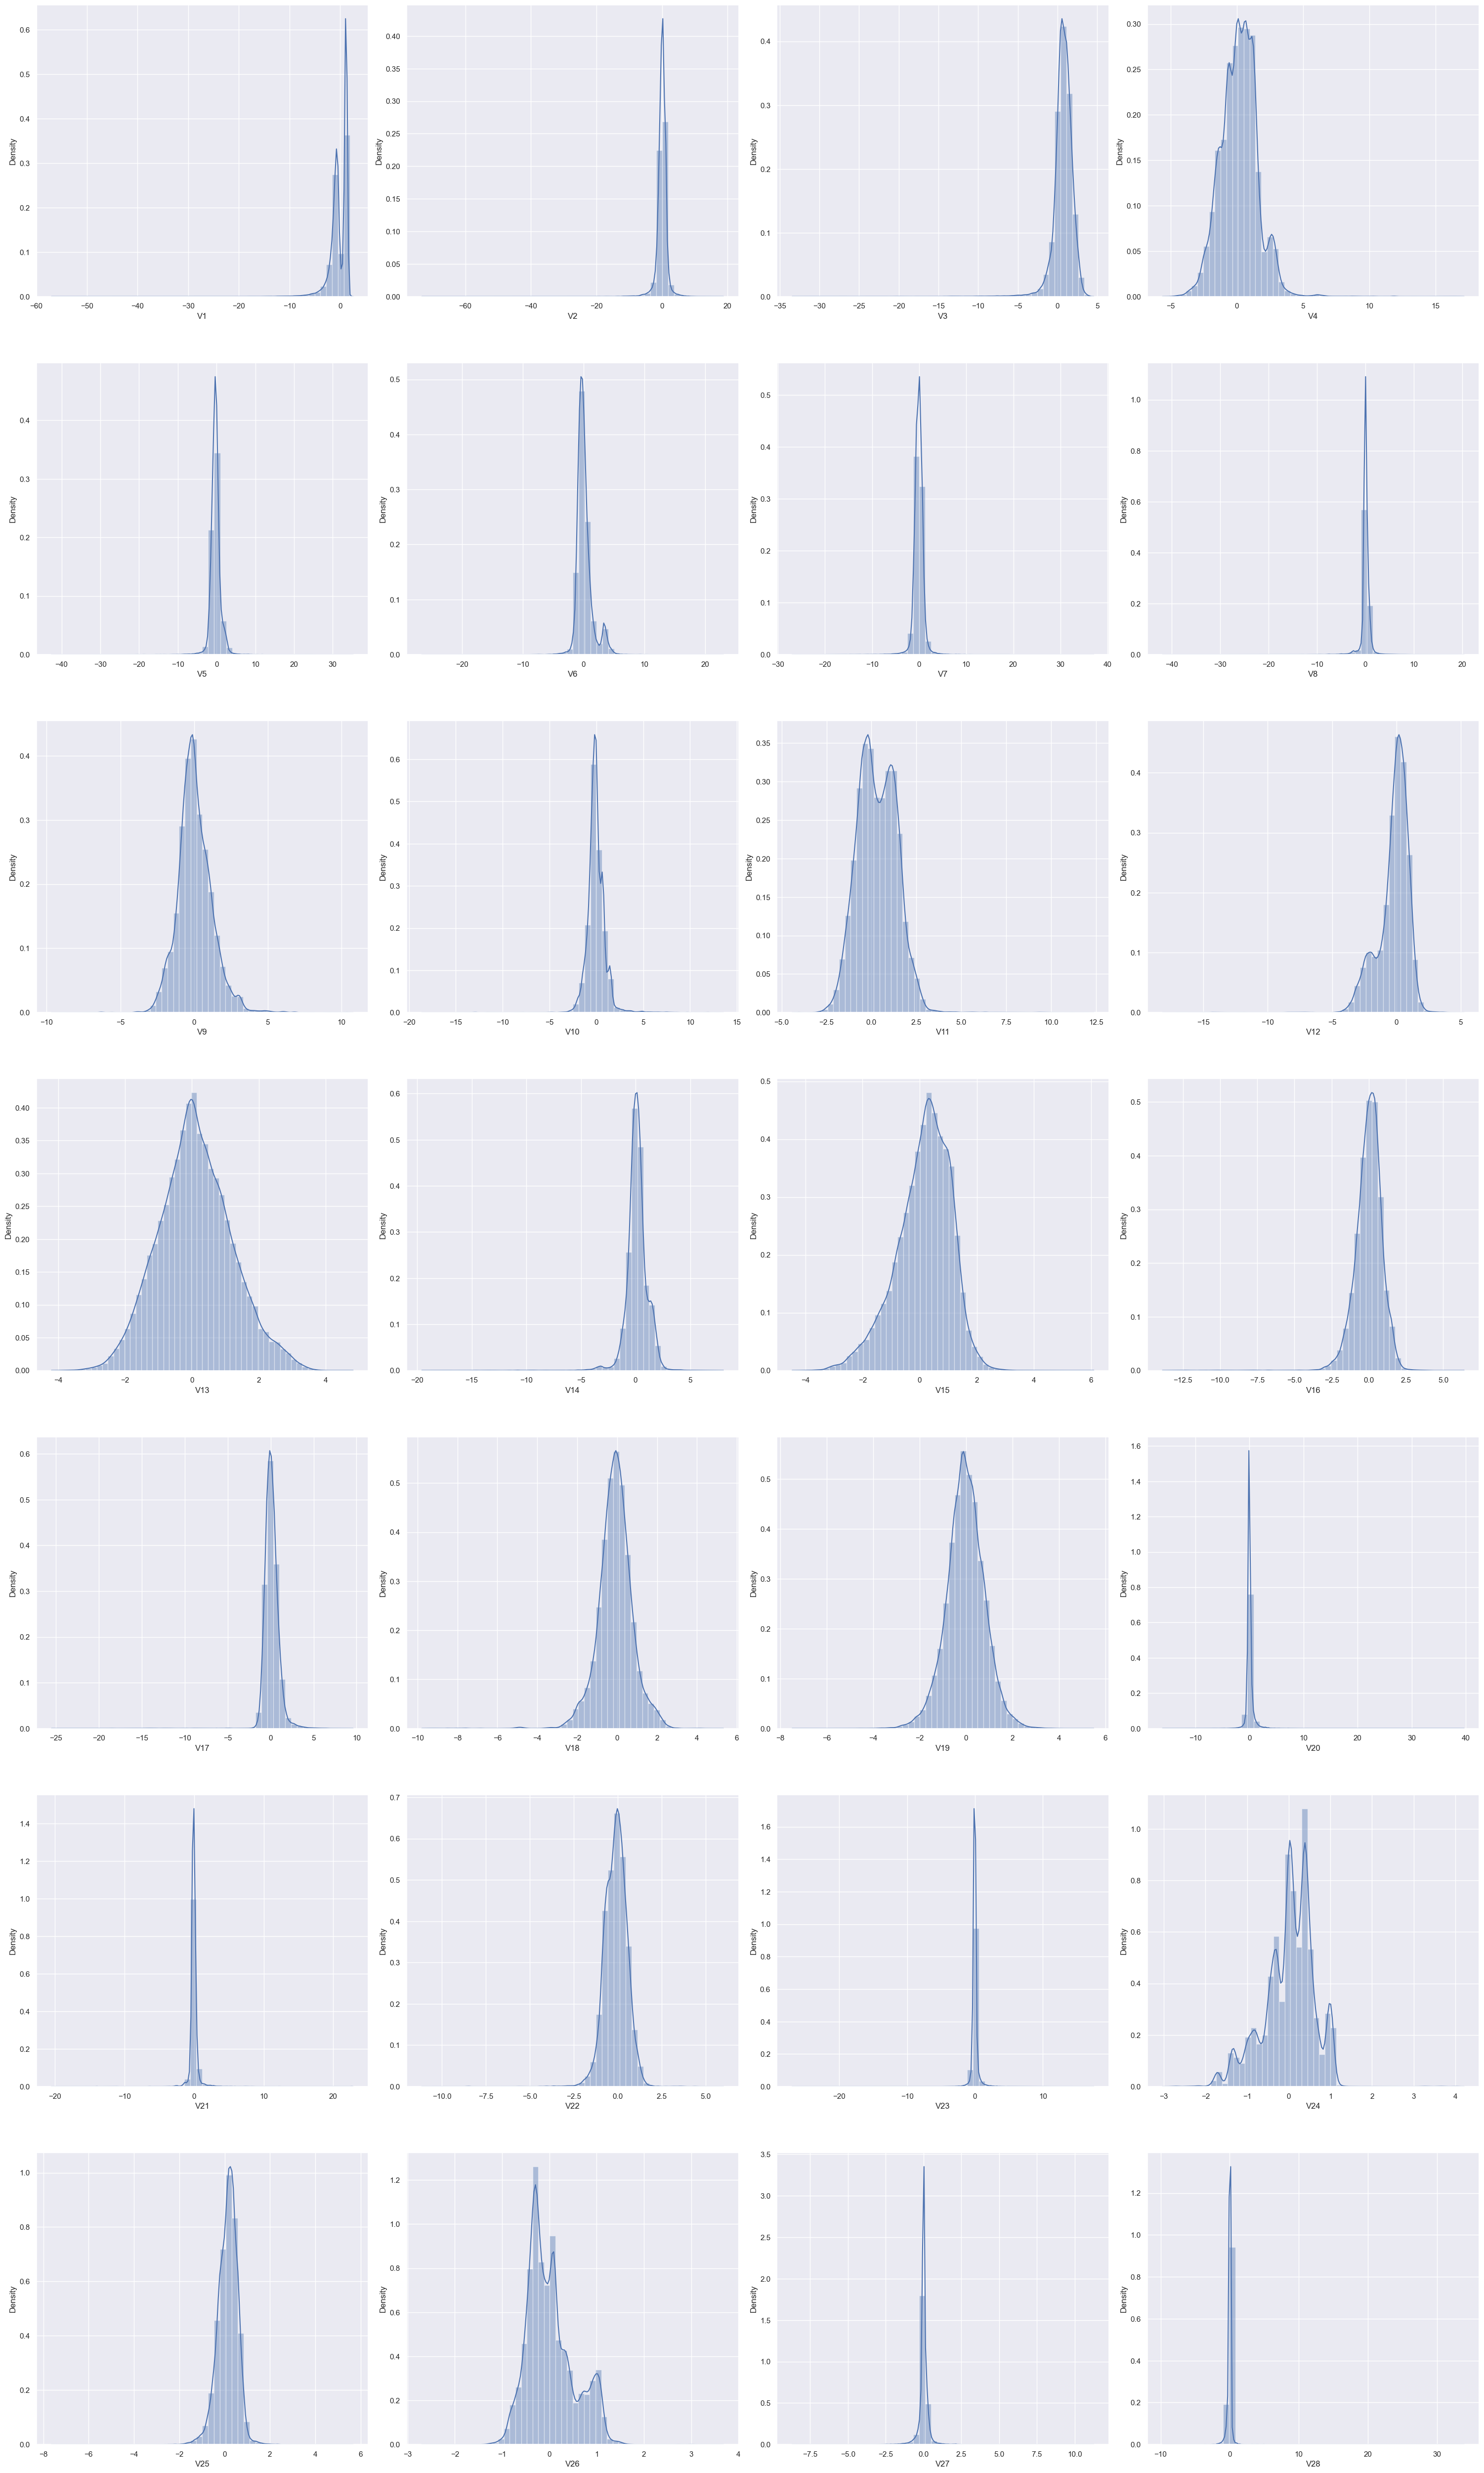

In [34]:
# Histograma de la caracteristicas V1-V28 (conjunto de datos grandes)

features_v= df_card.drop(columns=['Time', 'Amount', 'Class'], axis=1)

# grilla del plot 
fig, ax= plt.subplots(nrows=7, ncols=4, figsize=(30, 50))
index=0
ax= ax.flatten()

for col in features_v.columns:

    sns.distplot(features_v[col], ax=ax[index])
    index +=1

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5)
plt.show()

**Nota: Dado el desequilibrio significativo en las clases de este conjunto de datos, se recomienda medir la precisión utilizando el área bajo la curva de recuperación de precisión (AUPRC), ya que la precisión de la matriz de confusión no es significativa para una clasificación desequilibrada. Además, las características V1-V28 representan componentes principales obtenidos con PCA, lo que implica que los outliers en este conjunto de datos no representan un problema, ya que estas medidas estructuradas no dependen de ningún factor, sino más bien de la confidencialidad de las transacciones realizadas por el Banco.**

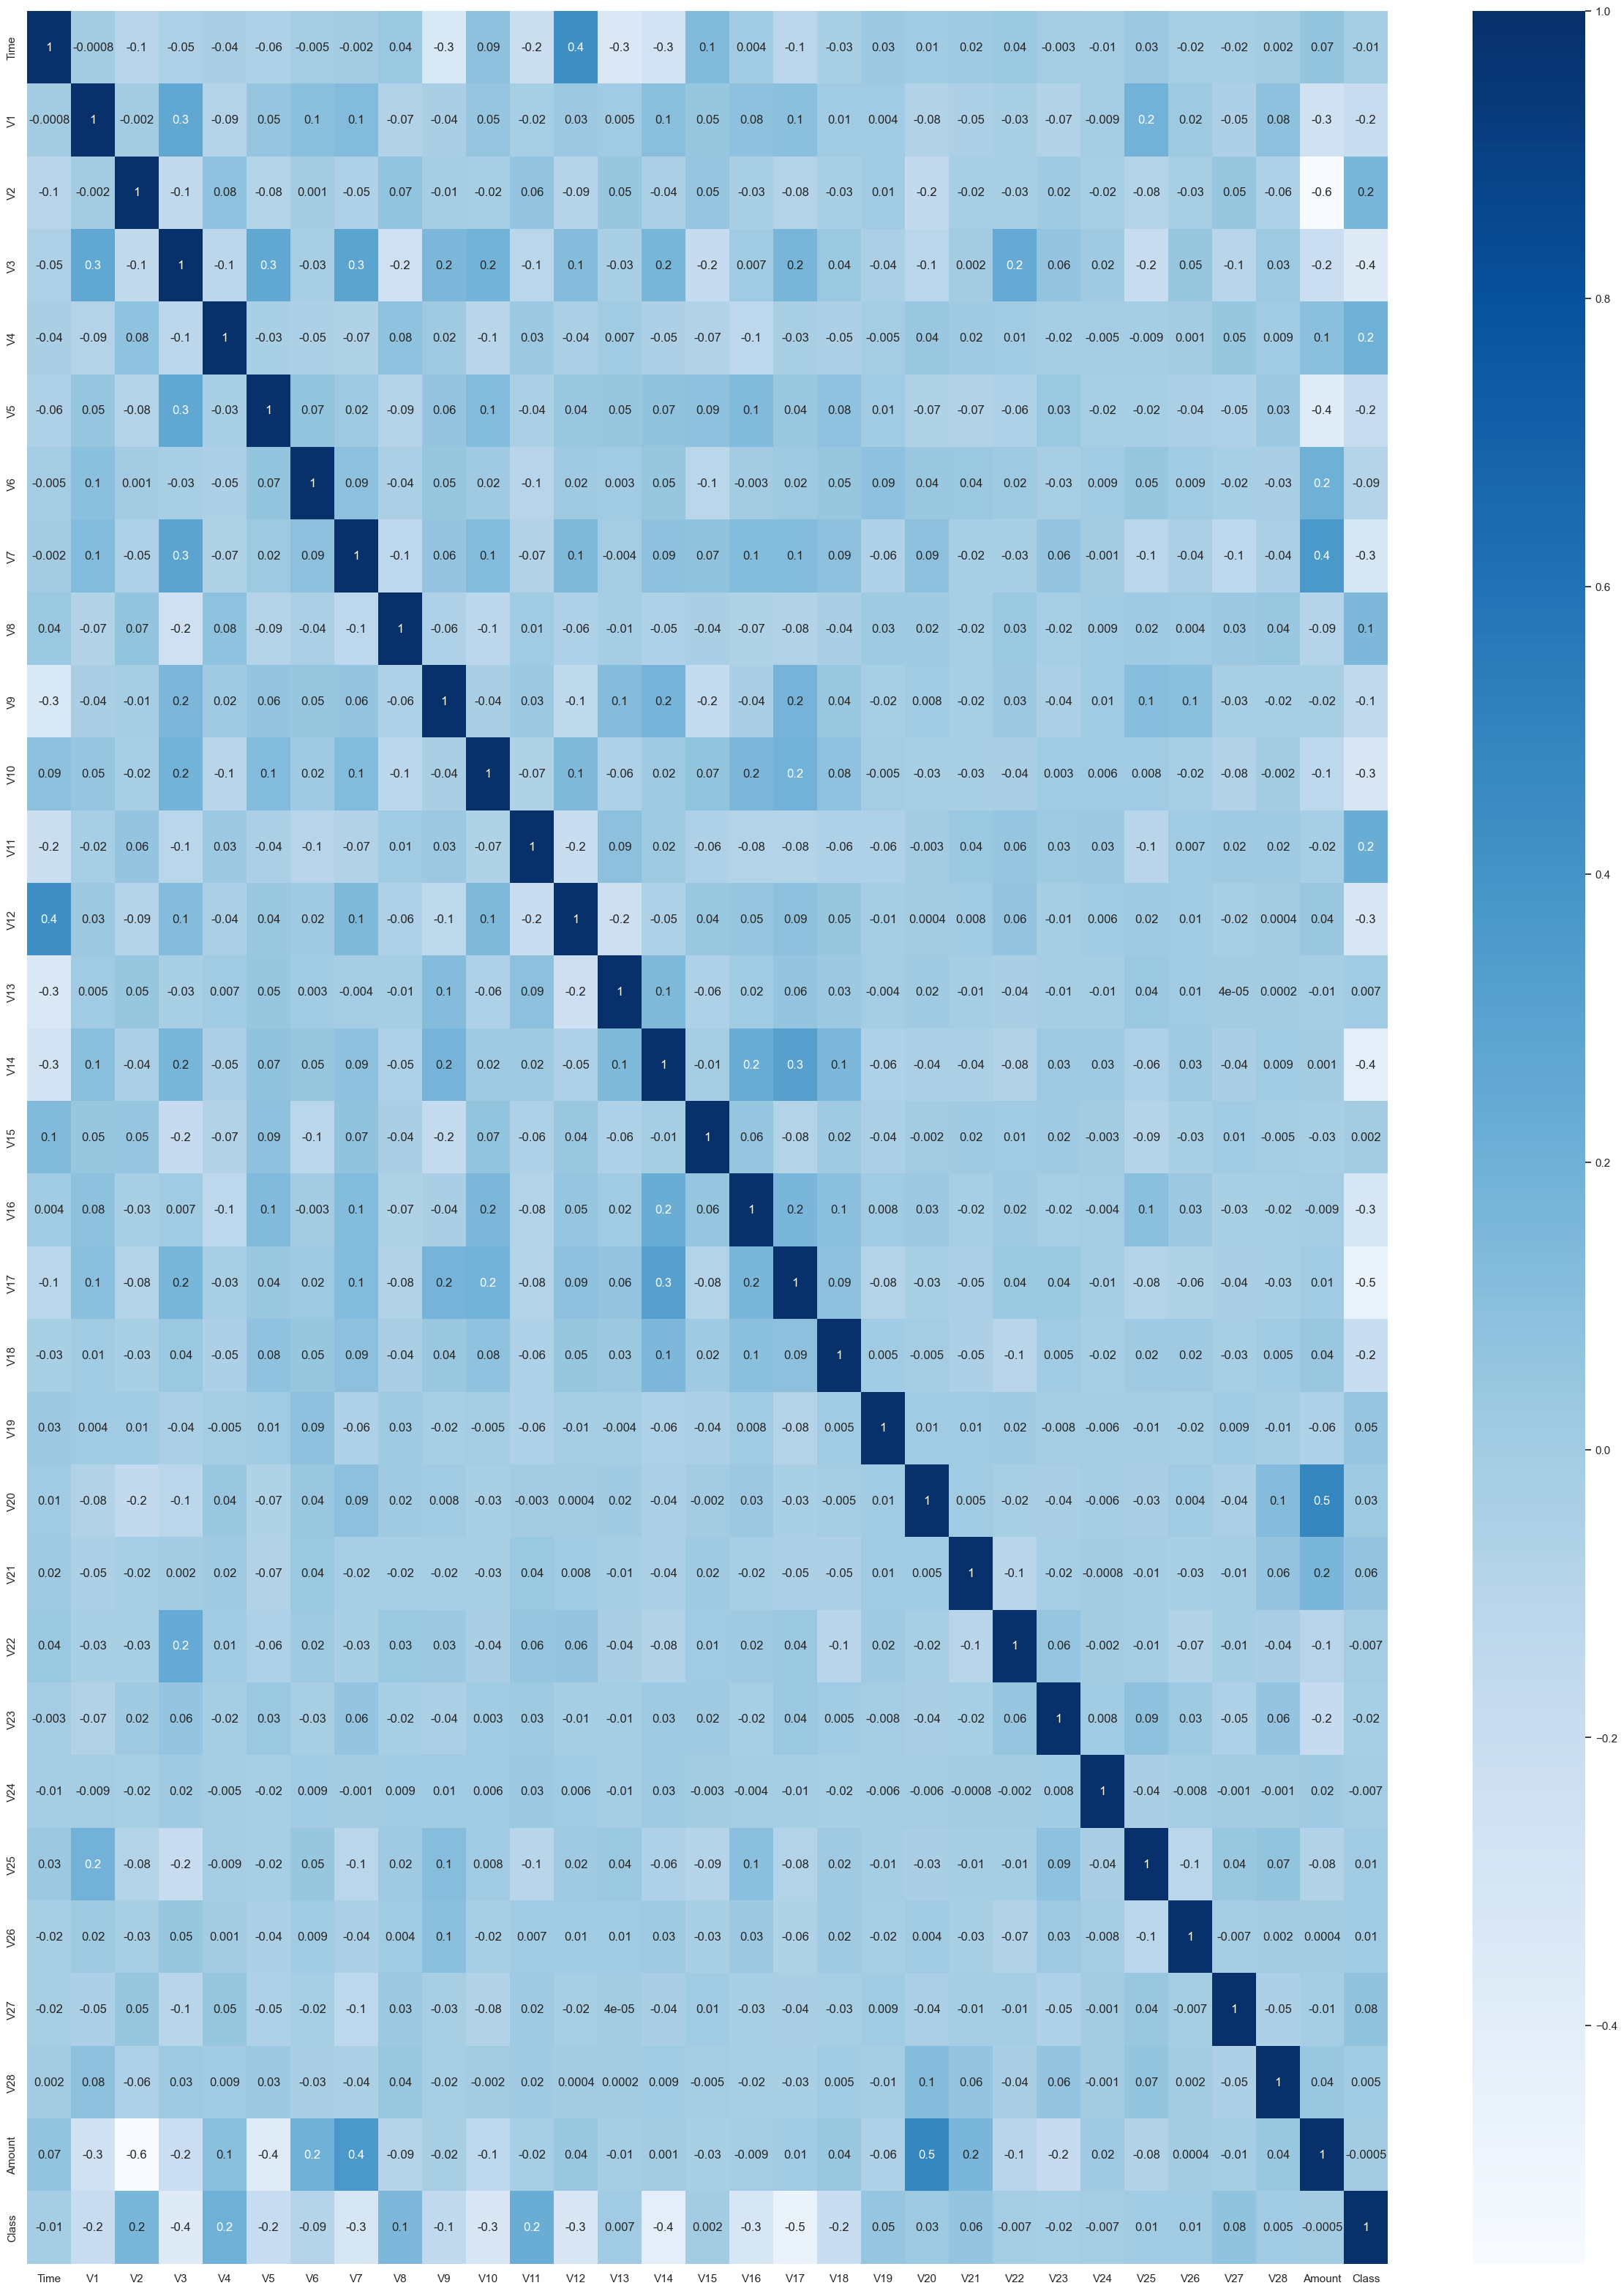

In [5]:
# Correlaciones 

corr= df_card.corr()
plt.figure(figsize=(30, 40))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='0.1g', )

plt.show()

**Nota: Como era de esperar, los datos presentan una baja correlación entre sí. En esta correlación de Pearson, las correlaciones más altas son escasas y sus valores rondan los 0.5, mientras que las correlaciones más bajas se sitúan alrededor de 0.003. Esto se debe a que las características más importantes han sido transformadas mediante PCA, lo que reduce las correlaciones entre los componentes principales. La transformación PCA está diseñada para crear componentes que capturen la máxima varianza posible en los datos originales mientras se asegura de que los nuevos componentes sean ortogonales entre sí, lo que resulta en bajas correlaciones.**

### Aplicamos Pipelines, Procesar los datos, Mas uniformes, estructurados y limpios para entrenar Modelo

1. Para este set de datos, solo haremos las trasformaciones para:** 

- Rellenar Los valores Faltantes (Numericos por la media)(Categoricas por la moda).
- Estandarizar las caracteristicas Time, Amount, no estan estandarizadas
- Balancear la data, en este caso para las clase Minoritaria

Nota: Pipeline, para missing values, transformaciones, estandarizacion, onehot, etc....

In [4]:
# Separamos Los datos Para aplicarlos al pipeline
# feat= features

feat_num= df_card.iloc[:, 1:-2] # Rellenar valores faltantes features v21-v28
feat_cat= df_card[['Class']] # Rellenar el ultimo valor faltante, categorica
feat_std= df_card[['Time', 'Amount']] # Estandarisar features y para Amount rellenar el ultimo valor faltante.


In [5]:
# Transformacion completa en X (Caracteristicas del Datasets)


# Pipeline para características numéricas
num_pipeline = Pipeline([
        ('imputer_num', SimpleImputer(strategy="median"))
    ])

# Pipeline para características a estandarizar e Imputar 'Amount'
std_pipeline= Pipeline([
        ('imputer_amount', SimpleImputer(strategy='median')),
        ('std', StandardScaler())
])

# Pipeline para características Categoricas 0, 1
cat_pipeline= Pipeline([
        ('imputer_cat', SimpleImputer(strategy='most_frequent'))
                     ])

# Combinación de todos los pipelines en un ColumnTransformer
full_pipeline = ColumnTransformer([ 

        ("num", num_pipeline, feat_num.columns),
        ('std', std_pipeline, feat_std.columns),
        ('cat', cat_pipeline, feat_cat.columns)
            
    ])

# Aplicar el pipeline completo al conjunto de datos
card_transformed= full_pipeline.fit_transform(df_card)

In [6]:
card_transformed

array([[-1.35980713, -0.07278117,  2.53634674, ..., -2.3381266 ,
         0.2013604 ,  0.        ],
       [ 1.19185711,  0.26615071,  0.16648011, ..., -2.3381266 ,
        -0.34496149,  0.        ],
       [-1.35835406, -1.34016307,  1.77320934, ..., -2.33805398,
         1.05298747,  0.        ],
       ...,
       [-2.67524369, -0.32325689,  0.5171953 , ...,  1.26723532,
        -0.12755565,  0.        ],
       [-0.96021586,  1.14054319,  1.03964724, ...,  1.26723532,
        -0.31179474,  0.        ],
       [-0.6919795 , -0.60717825,  2.37937321, ...,  1.26730793,
        -0.25821481,  0.        ]])

In [7]:
# Pasamos los datos a un data frame, de los datos prosesados.

df_clean= pd.DataFrame(card_transformed, columns=df_card.columns)
df_clean.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,-2.338127,0.201360,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-2.338127,-0.344961,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,-2.338054,1.052987,0.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,-2.338054,0.104240,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-2.337981,-0.094724,0.0


In [8]:
# Balanceamos Los datos de la etiquetas 0, 1, en este caso para la clase minoritaria
# Antes teniamos 61087 datos, ahora tenemos 121848 datos, ya que la clase 1.0 tenia 163.
# los datos Se balanceron de igual menera.

X= df_clean.iloc[:, :-1]
y= df_clean[['Class']]

smote= SMOTE(random_state=42)

X_smote, y_smote= smote.fit_resample(X, y)

In [9]:
# tomamo
print(X_smote.shape)
print(y_smote.shape)


(121848, 30)
(121848, 1)


In [10]:
# Separamos los datos Para Enrenar Y Testear

X_train_full, X_test, y_train_full, y_test= train_test_split(
         X_smote,
         y_smote,
         train_size=0.30, # reducir el numero de entrenamiento
         test_size=0.05, # reducir el numero de testeo
         random_state=42,
         stratify=y_smote,
         shuffle=True
) 

In [11]:
print(X_train_full.shape)
print(X_test.shape)
print(y_train_full.shape)
print(y_test.shape)

(36554, 30)
(6093, 30)
(36554, 1)
(6093, 1)


In [12]:
X_train, X_valid, y_train, y_valid= train_test_split(
         X_train_full,
         y_train_full,
         test_size=0.16666, # cantidad igual que testeo 6093
         random_state=42,
         stratify=y_train_full
) 

In [13]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

# datos de entrenamientos= 30461
# datos de testeteo= 6093
# datos de validacion= 6093

(30461, 30)
(6093, 30)
(30461, 1)
(6093, 1)


### Prueba t para comprobar todas las características y comprobar si el valor p <0,05

In [18]:
# t_statistic= stats.ttest_ind(X_train, X_test).pvalue<0.05
# X_train.columns[t_statistic] # verificar que columa son menores que 0.05

count=0
x= []  # guarda los nombres de las columans
p_stats=[] # guarda los valores del estudio (palue <0.05)

for col in X_train.columns:

    #t_statistic= stats.ttest_ind(X_train[col], X_test[col]).pvalue
    t_statistic, p_value = stats.ttest_ind(X_train[col], X_test[col])

    if p_value < 0.05:
        print(col, p_value)

        x.append(col)
        p_stats.append(p_value)
        count += 1 # permite contar los valores menores que 0.05

V14 0.04351113948981188


**Nota: Es importante destacar que el nivel de significancia se estableció con el objetivo de verificar la importancia de las variables. En este caso, solo dos valores parecen depender en gran medida de la variable objetivo. Sin embargo, este conjunto de datos ya ha sido procesado con el Análisis de Componentes Principales (PCA) para reducir su dimensionalidad. Dado que el PCA se basa en componentes lineales (ortogonales), se elimina la posibilidad de encontrar una correlación o dependencia entre las características. Esto significa que, aunque solo dos valores hayan demostrado una significancia menor a 0.05, no necesariamente implica que las demás características sean irrelevantes o no tengan impacto en la variable objetivo.**

### Crossvalidation  

- Diferentes modelos con Sklearn

Nota:Evalua y selecciona modelos de manera más robusta y precisa, Su propósito principal es estimar el rendimiento de un modelo en un conjunto de datos desconocido o no visto.


In [267]:
# validacion crusada  un unico modelo, prueva......

modelos= SVC(kernel='rbf')

kf= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring= ['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision', 'f1']

cv= cross_validate(modelos, X_train[:100], y_train[:100], cv=kf, scoring=scoring)

mean_scores= {metric: cv[f'test_{metric}'].mean() for metric in scoring} # filtara por col y sacar la media

#nur= pd.DataFrame(mean_scores) # pasar los valores a pandas

In [272]:
# validacion crusda par todos los modelos 

def cross_validation(X, y, n_splits= 5):

# Recorremos los modelo para el CV 
    models=[
            ('svc_rbf', SVC(kernel='rbf')),
            ('lr', LogisticRegression()),

           ('dt', DecisionTreeClassifier(max_depth=5, random_state=3)),
           ('rfc', RandomForestClassifier(max_depth=5, random_state=3)),
           ('abc', AdaBoostClassifier()),
           ('gbc', GradientBoostingClassifier()),
           ('xgbc',XGBClassifier()),

           ('gssnb', GaussianNB()),
           ('knc', KNeighborsClassifier() ),

           ('mlpc', MLPClassifier()),
           ('sgdc', SGDClassifier()),

           ]

    # Recorremos los modelo para el CV 

    results=[] # guarda los Resultados  de las medias totales de las columnas
    dfs= [] # guarda los resultados separados por cada validacion cruzada (3 de n_splits)

    for name, model in models:

        kf= StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        scoring= ['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision', 'f1']
        cv_results= cross_validate(model, X, y, cv= kf, scoring=scoring, return_train_score=False)

        # Calcular las medias de las métricas totales por columna (metricas)
        mean_scores = {metric: cv_results[f'test_{metric}'].mean() for metric in scoring}
        mean_scores['model'] = name
        results.append(mean_scores)

        # DataFrame, Resultados separados de cada n_splits
        average_score= pd.DataFrame(cv_results)
        average_score['model']= name
        dfs.append(average_score)

    # DataFrame, Resultados completos 
    results_total= pd.concat(dfs, ignore_index=True)

    # DataFrame, Resultados de las medias de las columnas
    results_mean = pd.DataFrame(results) 

    return results_mean,  results_total # media total de la metricas, # valores de la validacion cruzada

In [273]:
# final_mean= Contiene el promedio total de cada Evaluacion Cruzada por metricas de cada modelo.
# final_split= contiene todos los 3 (o 5) resultados de la evaluacion cruzada. 

final_mean, final_split= cross_validation(X_train, y_train, n_splits=3) # o n_splits=5


In [274]:
final_split

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,test_f1,model
0,10.328403,16.021106,0.978235,0.972374,0.984440,0.993891,0.992170,0.978369,svc_rbf
1,11.250156,18.065221,0.980205,0.977291,0.983258,0.994912,0.993374,0.980265,svc_rbf
2,17.533235,17.718882,0.978529,0.979286,0.977743,0.994348,0.992747,0.978514,svc_rbf
3,0.248528,0.119772,0.976462,0.979960,0.972819,0.996695,0.996624,0.976376,lr
4,0.207108,0.109794,0.975675,0.981844,0.969273,0.997289,0.997262,0.975518,lr
5,0.169180,0.119273,0.971142,0.981094,0.960804,0.996186,0.996095,0.970843,lr
6,0.891309,0.103304,0.977447,0.965081,0.990743,0.994826,0.992047,0.977743,dt
7,2.089040,0.300931,0.983258,0.979668,0.987000,0.997419,0.996264,0.983320,dt
8,1.178762,0.097317,0.981089,0.977330,0.985031,0.996363,0.995652,0.981165,dt
9,21.670385,1.049512,0.983061,0.995755,0.970258,0.998531,0.998659,0.982841,rfc


In [275]:
final_mean

,accuracy,precision,recall,roc_auc,average_precision,f1,model
0,0.978990,0.976317,0.981813,0.994384,0.992764,0.979049,svc_rbf
1,0.974426,0.980966,0.967632,0.996723,0.996661,0.974246,lr
2,0.980598,0.974026,0.987591,0.996202,0.994655,0.980743,dt
3,0.982601,0.994949,0.970127,0.998686,0.998733,0.982377,rfc
4,0.993303,0.992789,0.993828,0.999642,0.999631,0.993306,abc
5,0.995338,0.994820,0.995864,0.999684,0.999494,0.995341,gbc
6,0.998982,0.998426,0.999540,0.999917,0.999842,0.998983,xgbc
7,0.933653,0.978153,0.887138,0.959618,0.962255,0.930418,gssnb
8,0.996750,0.993544,1.000000,0.998982,0.997969,0.996761,knc
9,0.999343,0.998689,1.000000,0.999978,0.999976,0.999344,mlpc


1. Accuracy: Buena idea del rendimiento general del modelo en términos de la proporción de predicciones correctas.

2. ROC AUC: proporciona una visión más completa del rendimiento del modelo en términos de su capacidad para distinguir entre las dos clases (o mas clases).

In [310]:
# Ordenar por la métrica de interés, por ejemplo, ROC AUC
best_model = final_mean.sort_values(by='roc_auc', ascending=False).iloc[0]['model']# mejor Modelo 
best_model
#best_model.to_frame().style.background_gradient(cmap='summer_r')

'mlpc'

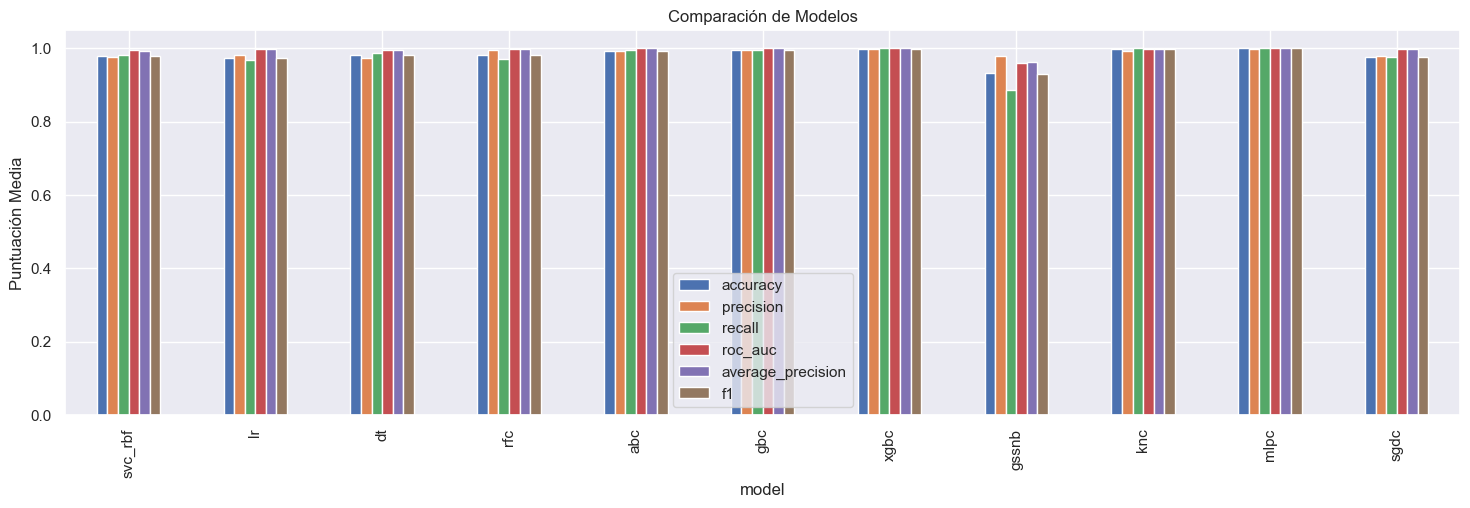

In [312]:
# Comparar los modelos visualmente
final_mean.plot(x='model', kind='bar', figsize=(18, 5))
plt.title('Comparación de Modelos')
plt.ylabel('Puntuación Media')
plt.show()


### Entrenamiento con el mejor modelo Sklearn


In [15]:
# Entrenar el mejor modelo en el conjunto de entrenamiento completo

best_model= 'mlpc' # este fue el que obtuvo mejor rendimiento en el CV

model_dict = {
           'svc_rbf': SVC(kernel='rbf'),
           'lr':LogisticRegression(),

           'dt': DecisionTreeClassifier(max_depth=5, random_state=3),
           'rfc': RandomForestClassifier(max_depth=5, random_state=3),
           'abc': AdaBoostClassifier(),
           'gbc': GradientBoostingClassifier(),
           'xgbc': XGBClassifier(),

           'gssnb': GaussianNB(),
           'knc': KNeighborsClassifier(),

           'mlpc': MLPClassifier(),
           'sgdc':SGDClassifier(),
}
best_model = model_dict[best_model]
best_model

MLPClassifier()

In [16]:
#1. Entrenar el modelos

best_model.fit(X_train, y_train)

MLPClassifier()

In [17]:
# 2. Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

In [18]:
# 3. Calcular las métricas de evaluación

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='binary')
test_recall = recall_score(y_test, y_pred, average='binary')
test_roc_auc = roc_auc_score(y_test, y_pred)
test_average_precision = average_precision_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='binary')

In [19]:
# Imprime
print("Métricas de evaluación en el conjunto de prueba:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"Average Precision: {test_average_precision:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Métricas de evaluación en el conjunto de prueba:
Accuracy: 0.9995
Precision: 0.9990
Recall: 1.0000
ROC AUC: 0.9995
Average Precision: 0.9990
F1 Score: 0.9995


In [20]:
# classification Report

class_report= classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3046
         1.0       1.00      1.00      1.00      3047

    accuracy                           1.00      6093
   macro avg       1.00      1.00      1.00      6093
weighted avg       1.00      1.00      1.00      6093



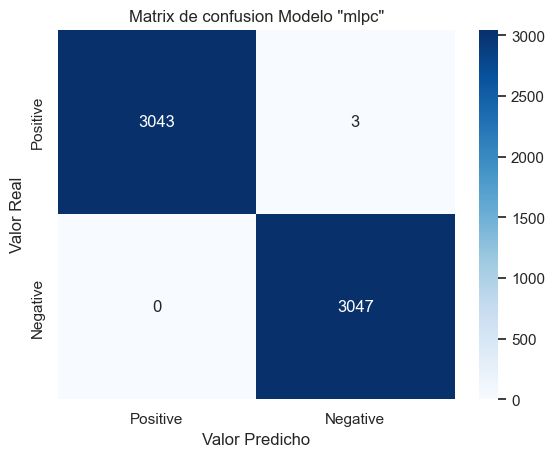

In [22]:
cm= confusion_matrix(y_test, y_pred)

classes=['Positive', 'Negative']

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels= classes, yticklabels= classes)

plt.title('Matrix de confusion Modelo "mlpc"')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

plt.show()

**Nota: El entrenamiento con el modelo 'mlpc' obtuvo un rendimeinto casi del 100%, cabe mencionar que todos los modelos obtuvieron un buen densempeño siendo el 'mlpc' mas alto po decimas, elegi el modelo en base de roc_auc mas alto ya que esta metrica proporciona una vision mas detallada del rendimiento del modelo en términos de su capacidad para distinguir entre las dos clases (0,  1).** 

In [14]:
# pasamos los valores a enteros ya que estan en flotantes

y_train= y_train.astype(int)
y_test= y_test.astype(int)
y_valid= y_valid.astype(int)

### Entrenamiento con redes Neuronales 

 - Capas Totalente Conectadas

In [208]:
# 1 Creacion de la red neuronal

model_nn=   keras.models.Sequential([

            layers.InputLayer(input_shape=X_train.shape[1:]),
            layers.Dense(60, activation='relu'),
            layers.Dense(30, activation='relu'),
            layers.Dense(1, activation='sigmoid')
])


In [209]:
model_nn.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 60)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,721 (14.54 KB)

 Trainable params: 3,721 (14.54 KB)

 Non-trainable params: 0 (0.00 B)

In [210]:
# Compilacion del Modelo

model_nn.compile(
    loss='binary_crossentropy',
    optimizer= keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

In [26]:
# Callback para guardar el mejor modelo, y hacer la parada temprana

checkpoint_cb = keras.callbacks.ModelCheckpoint('Modelos-Entrenados/best_model.keras', save_best_only=True)
e_stop= keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [212]:
# 3. entrenamiento de la red neuronal 

historial= model_nn.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    callbacks=[e_stop],
    batch_size=128,
    epochs= 20,
    verbose=2
)

Epoch 1/20
238/238 - 3s - 15ms/step - accuracy: 0.9544 - loss: 0.1268 - val_accuracy: 0.9895 - val_loss: 0.0407
Epoch 2/20
238/238 - 1s - 3ms/step - accuracy: 0.9933 - loss: 0.0271 - val_accuracy: 0.9974 - val_loss: 0.0211
Epoch 3/20
238/238 - 1s - 3ms/step - accuracy: 0.9974 - loss: 0.0147 - val_accuracy: 0.9975 - val_loss: 0.0139
Epoch 4/20
238/238 - 1s - 3ms/step - accuracy: 0.9984 - loss: 0.0100 - val_accuracy: 0.9984 - val_loss: 0.0103
Epoch 5/20
238/238 - 2s - 7ms/step - accuracy: 0.9990 - loss: 0.0070 - val_accuracy: 0.9987 - val_loss: 0.0086
Epoch 6/20
238/238 - 2s - 8ms/step - accuracy: 0.9990 - loss: 0.0055 - val_accuracy: 0.9985 - val_loss: 0.0078
Epoch 7/20
238/238 - 1s - 4ms/step - accuracy: 0.9993 - loss: 0.0044 - val_accuracy: 0.9987 - val_loss: 0.0071
Epoch 8/20
238/238 - 1s - 3ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9989 - val_loss: 0.0056
Epoch 9/20
238/238 - 1s - 6ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9989 - val_loss: 0.0054


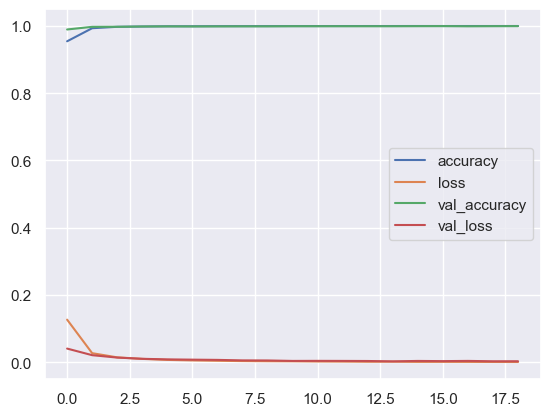

In [213]:
hist= historial.history
df_hist= pd.DataFrame(hist)
df_hist['epoch']= historial.epoch
df_hist.iloc[:,:-1].plot()
plt.show()

In [214]:
# valuacion del modelo
scores= model_nn.evaluate(X_test, y_test)
scores
# accuracy: 0.9989 - loss: 0.0048

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0027


[0.001921899034641683, 0.9993435144424438]

In [215]:
# Predciion del modelo 

y_pred_nn= model_nn.predict(X_test)
y_pred_nn

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[1.8394793e-08],
       [9.9774486e-01],
       [2.8909857e-11],
       ...,
       [9.9891341e-01],
       [9.9999946e-01],
       [2.0559726e-13]], dtype=float32)

In [216]:
# Fijamos un umbral para trasformar los datos a entero 0, 1

umbral=0.5
y_pred_int= np.where(y_pred_nn > umbral, 1, 0)
y_pred_int

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [217]:
# Presicion del modelo 
presicion= accuracy_score(y_test, y_pred_int)
presicion

0.9993435089446906

In [218]:
# Probamos el modelo con pocos datos 

# valor real 
print(y_test[:5])

X_new = X_test[:5]
y_pred= model_nn.predict(X_new)

umblar=0.5
y_pred_real= np.where(y_pred > 0.5, 1, 0)
print(y_pred_real)


       Class
20841      0
85968      1
24728      0
55046      0
65653      1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[0]
 [1]
 [0]
 [0]
 [1]]


In [219]:
# clasificacion de reportes 

class_report_nn= classification_report(y_test, y_pred_int)
print(class_report_nn)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3046
           1       1.00      1.00      1.00      3047

    accuracy                           1.00      6093
   macro avg       1.00      1.00      1.00      6093
weighted avg       1.00      1.00      1.00      6093



In [220]:
# Otras metricas Importantes para medir el modelo 

# 3. Calcular las métricas de evaluación

test_precision_nn = precision_score(y_test, y_pred_int, average='binary')
test_recall_nn= recall_score(y_test, y_pred_int, average='binary')
test_roc_auc_nn = roc_auc_score(y_test, y_pred_int)
test_average_precision_nn = average_precision_score(y_test, y_pred_int)
test_f1_nn= f1_score(y_test, y_pred_int, average='binary')

# Imprime
print("Otras Métricas de evaluación, conjunto de prueba: \n")

print(f"Precision: {test_precision_nn:.4f}")
print(f"Recall: {test_recall_nn:.4f}")
print(f"ROC AUC: {test_roc_auc_nn:.4f}")
print(f"Average Precision: {test_average_precision_nn:.4f}")
print(f"F1 Score: {test_f1_nn:.4f}")

Otras Métricas de evaluación, conjunto de prueba: 

Precision: 0.9987
Recall: 1.0000
ROC AUC: 0.9993
Average Precision: 0.9987
F1 Score: 0.9993


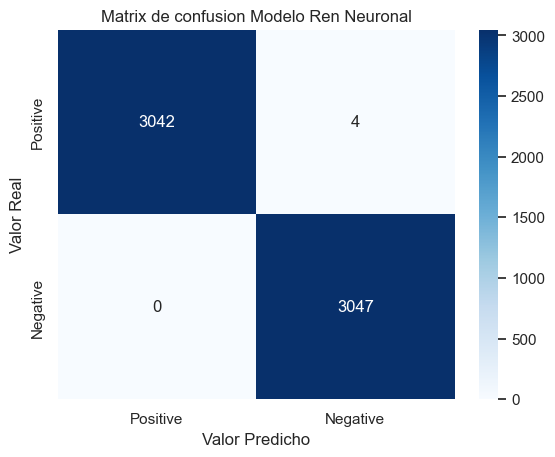

In [221]:
# Matrix de confucion Ren Neuronal 

cm_nn= confusion_matrix(y_test, y_pred_int)

classes=['Positive', 'Negative']

sns.heatmap(cm_nn, annot=True, fmt='g', cmap='Blues', xticklabels= classes, yticklabels= classes)

plt.title('Matrix de confusion Modelo Ren Neuronal')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

plt.show()

### FineTune de modelos 

- Sklearn = GridSearch, RandomizedSearchCV

**Parametros que se pueden modificar en MPLClassifier**

(hidden_layer_sizes: ArrayLike | tuple[int] = ..., activation: Literal['relu', 'identity', 'logistic', 'tanh'] = "relu", *, solver: Literal['lbfgs', 'sgd', 'adam'] = "adam", alpha: Float = 0.0001, batch_size: Int | str = "auto", learning_rate: Literal['constant', 'invscaling', 'adaptive'] = "constant", learning_rate_init: Float = 0.001, power_t: Float = 0.5, max_iter: Int = 200, shuffle: bool = True, random_state: Int | RandomState | None = None, tol: Float = 0.0001, verbose: bool = False, warm_start: bool = False, momentum: Float = 0.9, nesterovs_momentum: bool = True, early_stopping: bool = False, validation_fraction: Float = 0.1, beta_1: Float = 0.9, beta_2: Float = 0.999, epsilon: Float = 1e-8, n_iter_no_change: Int = 10, max_fun: Int = 15000) -> None

In [38]:
# Afinamos el modelo de sklearn 'mlpc' con parametros mas importantes

model_mplc= MLPClassifier(random_state=42)

param_grid= {
            'hidden_layer_sizes': randint(2, 4),
            'learning_rate_init': [0.01, 0.001, 0.0001],
            'max_iter':[200, 400, 600],
            'alpha': [0.01, 0.001, 0.0001],
            'learning_rate': ['constant', 'adaptive'],
            #'solver': ['sgd', 'adam']
            #activation': ['relu', 'logistic']
            #'beta_1': [0.1, 0.5, 0.9],
            #'beta_2':[0.111, 0.555, 0.999],
            #'epsilon':randint(1e-5, 1e-8),
            #'momentum':[0.5, 0.9]
}

kf_tune= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#scoring_tune= ['average_precision'] # o accuracy
search_tune= RandomizedSearchCV(estimator= model_mplc, param_distributions= param_grid, cv=kf_tune, scoring='average_precision', n_jobs=-1, random_state=42)

# Entrenamos el Random Search

search_tune.fit(X_train, y_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=MLPClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'activation': ['relu', 'logistic'],
                                        'alpha': [0.01, 0.001, 0.0001],
                                        'hidden_layer_sizes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026AB4BDBC90>,
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'learning_rate_init': [0.01, 0.001,
                                                               0.0001],
                                        'max_iter': [200, 400, 600],
                                        'solver': ['sgd', 'adam']},
                   random_state=42, scoring='average_precision')

In [39]:
# Verificar los mejores parametros del modelo

print(search_tune.best_params_)
print(search_tune.best_estimator_)
print(search_tune.best_score_)

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 3, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 400, 'solver': 'sgd'}
MLPClassifier(alpha=0.001, hidden_layer_sizes=3, learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=400, random_state=42,
              solver='sgd')
0.9990795785349441


In [45]:
# 1. Entrenamos el modelo nuevamente con los parameros encontrados

model_mplc_tune= MLPClassifier(activation= 'relu', alpha= 0.001, hidden_layer_sizes= 3, learning_rate= 'adaptive', learning_rate_init= 0.001, max_iter= 400, solver= 'adam')
model_mplc_tune.fit(X_train, y_train)

# Otra forma de entrenara los modelos con los parametros, pero hay que ir buscando hasta encontrar os mejores 

#model_mplc_tune= search_tune.best_estimator_.fit(X_train, y_train)

#model_mplc= MLPClassifier(search_tune.best_params_)
#model_mplc

MLPClassifier(alpha=0.001, hidden_layer_sizes=3, learning_rate='adaptive',
              max_iter=400)

In [46]:
# Precicion del modelo 

y_pred_mlpc= model_mplc_tune.predict(X_test)
y_pred_mlpc


array([0., 1., 0., ..., 1., 1., 0.])

In [47]:
acc= accuracy_score(y_test, y_pred_mlpc)
aps= average_precision_score(y_test, y_pred_mlpc)
class_report= classification_report(y_test, y_pred_mlpc)

print(acc)
print(aps)
print(class_report)


0.9950763170851797
0.9913597902614283
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      3046
         1.0       0.99      1.00      1.00      3047

    accuracy                           1.00      6093
   macro avg       1.00      1.00      1.00      6093
weighted avg       1.00      1.00      1.00      6093



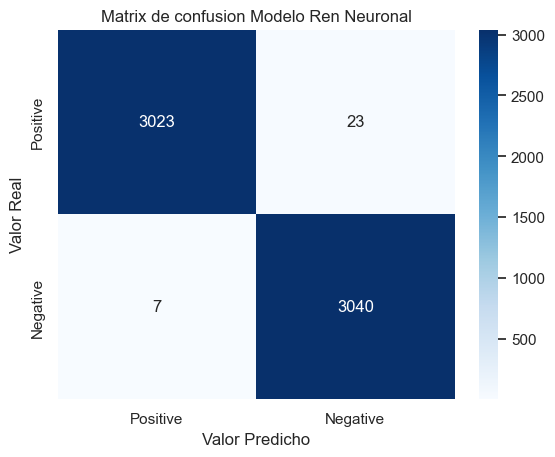

In [48]:
cm_nn= confusion_matrix(y_test, y_pred_mlpc)

classes=['Positive', 'Negative']

sns.heatmap(cm_nn, annot=True, fmt='g', cmap='Blues', xticklabels= classes, yticklabels= classes)

plt.title('Matrix de confusion Modelo Ren Neuronal')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

plt.show()

**Nota: El modelo Afinado mlpc, no muestra ser mejor que el primer modelo de mlpc, esto puede ser devido a algun parametro, sin ambargo las mericas son casi parasidas con un 0,99..% de aproimacion, en lo unico que cambia es a la hora de clasificar los falsos positivos y los falsos negativos**

**Nota: Se deve de hacer varios ajustes hasta encontrar los parametros adecuados.**

### FineTune de modelos 

- Tensorflow.Keras = RandomSearch, GridSearch

In [15]:
# 1. Creamos el modelo para ajute de hiperparamentros

def buil_model(hp):

    model_tune= keras.models.Sequential()

    # capa de entrada
    #model_tune.add(layers.InputLayer(input_shape=X_train.shape[1:]))
    model_tune.add(layers.Dense(units=hp.Int('input_units', min_value=30, max_value=120, step=30), activation='relu', input_shape=X_train.shape[1:]))

    # capa ocultas
    for i in range(hp.Int('num_layers', 1, 4)):
        model_tune.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=30, max_value=120, step=30), activation='relu'))

    # capa de salida 
    model_tune.add(layers.Dense(1, activation='sigmoid'))

    # afinar Learining_rate
    #learning_rate= hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    lr= hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # afinar batch_size
    #batch_size= hp.Choice('batch_size', values=[16, 32, 64, 128])

    # afinar epochs (epocas)
    epochs= hp.Choice('epochs', values=[30, 50, 100])

    # 2 Compilacion del Modelo 

    model_tune.compile(
            loss='binary_crossentropy',
            optimizer= keras.optimizers.Adam(learning_rate=lr),
            metrics=['accuracy']
    )

    return model_tune

In [16]:
# 3. Armar afinador, establecer numero de rondas y compinaciones

tuner= RandomSearch(
      buil_model,
      objective='val_accuracy',
      max_trials=5,
      executions_per_trial=3,
      directory='Guardar-Model-Callbacks', # donde guardamos los ajustes del Iperparametros 
      project_name='fraude_hp_tuner', # Normabre final del achivo
)

Reloading Tuner from Guardar-Model-Callbacks\fraude_hp_tuner\tuner0.json


**NOTA-IMPORTANTE: Para cargar el mejor modelo luego de entrenarlo (no importa si se cerro la session), devemos Ejecutar el modelo al que se le aplicara la busqueda de hiperparametros (buid_model(hp),) y tambien ejecutar el armar Afinador (tuner=RandomSearch), este recargara el callbacks con el mejor modelo con los pesos, en este caso tuner0.json ubicado en el ultimo trial_4**

Reloading Tuner from Guardar-Model-Callbacks\fraude_hp_tuner\tuner0.json

In [17]:
# Mostrar resumen del espacio de búsqueda
tuner.search_space_summary()

Search space summary
Default search space size: 8
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 120, 'step': 30, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 120, 'step': 30, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
epochs (Choice)
{'default': 30, 'conditions': [], 'values': [30, 50, 100], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 120, 'step': 30, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 120, 'step': 30, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 120, 'step': 30, 'sampling': 'linear'}


In [116]:
# Entrenar el buscador de Parametros

hist_tune= tuner.search(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs= 20 # inicializado en 20, pero puede buscar otro
    #epochs=hp.Int('epochs', 30, 100, step=10),  # Búsqueda de epochs, asi se busca este parametro.
    #batch_size=hp.Choice('batch_size', values=[16, 32, 64, 128])  # Búsqueda de batch_size, asi se busca este parametro.
)

Trial 5 Complete [00h 06m 18s]
val_accuracy: 0.9995623230934143

Best val_accuracy So Far: 0.9995623230934143
Total elapsed time: 00h 30m 55s


In [21]:
# Obtener el mejor conjunto de hiperparámetros una ves entrado o Guardado el buscador de parametros 
# Tambien lo podemos cargar si kerastuner guarda los tria's, en este caso estara en el untimo trial_4 tuner0.json 

best_hp= tuner.get_best_hyperparameters(num_trials=1)[0]

# Convertir los mejores hiperparámetros a un diccionario
best_hp_dict= best_hp.values

print(best_hp_dict)

#{'input_units': 60, 'num_layers': 3, 'units_0': 90, 'learning_rate': 0.001, 'epochs': 100, 'units_1': 60, 'units_2': 90, 'units_3': 30}

{'input_units': 60, 'num_layers': 3, 'units_0': 90, 'learning_rate': 0.001, 'epochs': 100, 'units_1': 60, 'units_2': 90, 'units_3': 30}


In [22]:
# Armamos el modelo final con los hiperparametros encontrados 

model_final= tuner.hypermodel.build(best_hp)
model_final.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 60)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 90)             │         5,490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 60)             │         5,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 90)             │         5,490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,391 (71.84 KB)

 Trainable params: 18,391 (71.84 KB)

 Non-trainable params: 0 (0.00 B)

**Nota: Cabe recordar que el mejor modelo ubicado en 'model_final= tuner.hypermodel.build(best_hp)' aunque tenga guardado el epochs y batch_size no significa que se valla a entrenar con estos hiperparametro hayado, hay que epecificarlo nuevamente al ajustar el modelo con los hiperparametros hayados.**

In [25]:
# Entrenamos eL Modelo Final

hist_final= model_final.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, e_stop],
    epochs=best_hp.get('epochs'),
    batch_size=128, # Buscar el mejor batch_size=best_hp.get('batch_size'), pero si se llega a entrenar en tuner.search.
    #shuffle=True,
    verbose=2
)

Epoch 1/100
238/238 - 5s - 21ms/step - accuracy: 0.9742 - loss: 0.0630 - val_accuracy: 0.9984 - val_loss: 0.0183
Epoch 2/100
238/238 - 1s - 4ms/step - accuracy: 0.9990 - loss: 0.0088 - val_accuracy: 0.9993 - val_loss: 0.0094
Epoch 3/100
238/238 - 2s - 7ms/step - accuracy: 0.9993 - loss: 0.0061 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 4/100
238/238 - 3s - 13ms/step - accuracy: 0.9996 - loss: 0.0035 - val_accuracy: 0.9995 - val_loss: 0.0046
Epoch 5/100
238/238 - 1s - 5ms/step - accuracy: 0.9996 - loss: 0.0033 - val_accuracy: 0.9993 - val_loss: 0.0073
Epoch 6/100
238/238 - 1s - 6ms/step - accuracy: 0.9993 - loss: 0.0037 - val_accuracy: 0.9992 - val_loss: 0.0064
Epoch 7/100
238/238 - 2s - 7ms/step - accuracy: 0.9987 - loss: 0.0048 - val_accuracy: 0.9992 - val_loss: 0.0043
Epoch 8/100
238/238 - 3s - 14ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 9/100
238/238 - 1s - 5ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9993 - val_lo

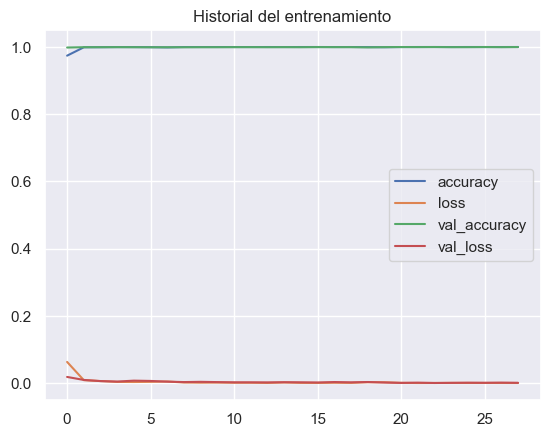

In [28]:
# Historial del Entrenamiento 

hist= hist_final.history
pd_hist= pd.DataFrame(hist)
pd_hist['epoch']= hist_final.epoch
pd_hist.iloc[:, :-1].plot()
plt.title('Historial del entrenamiento')
plt.show()

In [29]:
# Evaluar el mejor modelo
loss, accuracy = model_final.evaluate(X_valid, y_valid) # o X_test, y_test
print(f"Mejor modelo - Pérdida: {loss}, Exactitud: {accuracy}")

# accuracy: 0.9993 - loss: 0.0018
# accuracy: 0.9999 - loss: 2.2057e-04

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 2.2057e-04
Mejor modelo - Pérdida: 0.00034957032767124474, Exactitud: 0.9998358488082886


In [30]:
# Precicion del modelo, y prediccion del modelo 

y_pred_final= model_final.predict(X_test)

# Pasamos los valores continuos de las prediciones a enteros 0 y 1
umbral=0.5
y_pred_fin= np.where(y_pred_final > umbral, 1, 0)

acc= accuracy_score(y_test, y_pred_fin)
ave_pre_sco= average_precision_score(y_test, y_pred_fin)
cr= classification_report(y_test, y_pred_fin)

# ver resultados
print('Exactitud: ', acc)
print('average precision: ', ave_pre_sco)
print(cr)

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Exactitud:  0.999507631708518
average precision:  0.9990163934426229
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3046
           1       1.00      1.00      1.00      3047

    accuracy                           1.00      6093
   macro avg       1.00      1.00      1.00      6093
weighted avg       1.00      1.00      1.00      6093



In [43]:
# Testiamos el modelo con algunos ejemplos 

# Valor Real
y_new= y_test[:5]
print('Valores Reales: \n', y_new)

# Valor Predicho 

X_new= X_test[:5]
y_prueva= model_final.predict(X_new)

# Establecemos un umbral para que el valor final sea 1, 0
y_prueva_np= np.where(y_prueva > umbral, 1, 0)

# establecemos un umbral
print('Valores Predichos: \n', y_prueva_np)


Valores Reales: 
        Class
20841      0
85968      1
24728      0
55046      0
65653      1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Valores Predichos: 
 [[0]
 [1]
 [0]
 [0]
 [1]]


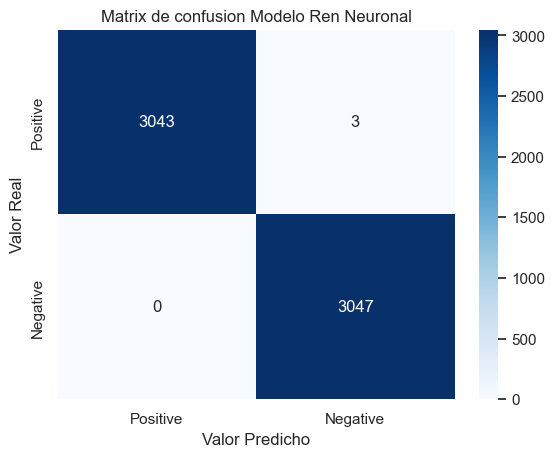

In [44]:
# Confusion Matrix afinacion de la red neuronal final

cm_nn= confusion_matrix(y_test, y_pred_fin)

classes=['Positive', 'Negative']

sns.heatmap(cm_nn, annot=True, fmt='g', cmap='Blues', xticklabels= classes, yticklabels= classes)

plt.title('Matrix de confusion Modelo Ren Neuronal')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

plt.show()

**Nota Final:**

El modelo fue entrenado satisfactoriamente para abordar el desafío de detectar fraudes en transacciones de una institución bancaria. Se lograron resultados excelentes tanto para el MLPClassifier como para la red neuronal secuencial. Los gráficos muestran un comportamiento estable, sin indicios de overfitting ni underfitting.

Es importante destacar que las transacciones fueron procesadas mediante PCA para reducir la dimensionalidad de los datos. Sin embargo, es crucial tener en cuenta que los datos no representan las transacciones reales debido a la seguridad e integridad de los datos, y tampoco reflejan los datos obtenidos en el momento debido al uso de PCA.

Las diversas métricas de precisión para ambos modelos fueron aproximadamente 0.999, y para la red neuronal se registró una pérdida de 2.2057e-04. En la matriz de confusión, solo obtuvimos tres valores de falsos positivos.

Es relevante mencionar que las métricas se calcularon tanto para los datos de prueba como para los de validación. Para seleccionar el mejor modelo, utilizamos validación cruzada con 10 modelos distintos, eligiendo el mejor modelo al calcular las medias de cada métrica con n_splits=5. Optamos por la métrica roc_auc, ya que esta representa mejor el rendimiento en términos de capacidad para distinguir entre las dos clases (0 y 1).

Finalmente, realizamos un ajuste de hiperparámetros (tuning) para la red neuronal con el fin de buscar los mejores parámetros, reduciendo así la pérdida y maximizando la precisión. Para ambos modelos, la precisión fue idéntica, mostrando únicamente tres falsos positivos. El modelo se comporta de manera óptima incluso con valores no vistos previamente, además de los conjuntos de prueba y validación.

ING. Angel Alaguera.